## <font color="Indigo">課題 タイタニック生存予測 ランダムフォレスト</font>
https://diver.diveintocode.jp/textbooks/530

#### 全体の流れ
問題提起  
データ取得  
データ可視化  
前処理  
モデル選択  
データセット分割  
学習  
評価  

#### 必要なライブラリをimportする

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import cross_validation
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from scipy.stats import zscore

%matplotlib inline

/Users/yasu/.pyenv/versions/anaconda3-4.3.0/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### <font color="Indigo">1. データ取得 / データ読み込み / データ確認 / sample</font>

In [2]:
data_train = pd.read_csv('train.csv')
data_test = pd.read_csv('test.csv')
data_train.sample(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
154,155,0,3,"Olsen, Mr. Ole Martin",male,NaN,0,0,Fa 265302,7.3125,NaN,S
761,762,0,3,"Nirva, Mr. Iisakki Antino Aijo",male,41.0,0,0,SOTON/O2 3101272,7.1250,NaN,S
718,719,0,3,"McEvoy, Mr. Michael",male,NaN,0,0,36568,15.5000,NaN,Q
464,465,0,3,"Maisner, Mr. Simon",male,NaN,0,0,A/S 2816,8.0500,NaN,S
554,555,1,3,"Ohman, Miss. Velin",female,22.0,0,0,347085,7.7750,NaN,S


### <font color="Indigo">2. 前処理について記述せよ</font>
##### ・前処理とは何か
###### 答え:  
コンピュータが機械学習において、データを限りなく正しく扱えるように整備すること。
##### ・なぜ前処理を行う必要があるのか
###### 答え:  
機械学習において、扱えないデータであったり、全体の精度を歪ませるデータであったりするため、それらを補正して機械学習に最適な特徴量にさせる必要があるため。
##### ・前処理は具体的に何を行うか(3つ以上記述せよ)
###### 答え:  
1. 欠損値の除去あるいは穴埋め  
2. 外れ値の除去  
3. カテゴリデータ処理  

##### ・前述した具体的な前処理について、その前処理を行うと何を得ることができるか(記述したそれぞれの前処理例について記述せよ)  
###### 答え:
1. 欠損値の除去あるいは穴埋め  
扱えるデータになる、あるいは、データ全体の精度が高まる。
2. 外れ値の除去  
扱えるデータになる、あるいは、データ全体の精度が高まる。また、過学習の防止にも繋がる。
3. カテゴリデータ処理  
データ分類・判定処理を最適化させることができる。

### <font color="Indigo">3. 2/前処理について記述せよ</font>
##### ・前処理について記述せよの調査により、データを確認する際にどのような点を見るとよいか、3つ以上記述せよ。
###### 答え:
1. 欠損値が全体の精度に与える影響度合い。(例えば、欠損率が高いため、特徴量として扱えないなど。)
2. 外れ値が本当に外れ値として処理して良いのか。(例えば、正規分布で95%範囲に入らない場合は外れ値にするなど。)
2. カテゴリデータがどの様な特徴量に分類できるか。(例えば、順序付けできるのか(ordinal)、あるいは順序付けできないのか(nominal)など。)

### <font color="Indigo">4. 前処理を行う</font>

In [3]:
# 前処理1
def simplify_ages(df):
    df.Age = df.Age.fillna(-0.5)
    bins = (-1, 0, 5, 12, 18, 25, 35, 60, 120)
    group_names = ['Unknown', 'Baby', 'Child', 'Teenager', 'Student', 'Young Adult', 'Adult', 'Senior']
    categories = pd.cut(df.Age, bins, labels = group_names)
    df.Age = categories
    return df

def simplify_cabins(df):
    df.Cabin = df.Cabin.fillna('N')
    df.Cabin = df.Cabin.apply(lambda x: x[0])
    return df

def simplify_fares(df):
    df.Fare = df.Fare.fillna(-0.5)
    bins = (-1, 0, 8, 15, 31, 1000)
    group_names = ['Unknown', '1_quartile', '2_quartile', '3_quartile', '4_quartile']
    categories = pd.cut(df.Fare, bins, labels = group_names)
    df.Fare = categories
    return df

def format_name(df):
    df['Lname'] = df.Name.apply(lambda x: x.split(' ')[0])
    df['NamePrefix'] = df.Name.apply(lambda x: x.split(' ')[0])
    return df

def format_embarked(df):
    df.Embarked = df.Embarked.fillna('N')
    return df

def drop_features(df):
    return df.drop(['Ticket', 'Name'], axis = 1)

def transform_features(df):
    df = simplify_ages(df)
    df = simplify_cabins(df)
    df = simplify_fares(df)
    df = format_name(df)
    df = format_embarked(df)
    df = drop_features(df)
    return df

data_train = transform_features(data_train)
data_test = transform_features(data_test)
data_train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Lname,NamePrefix
0,1,0,3,male,Student,1,0,1_quartile,N,S,"Braund,","Braund,"
1,2,1,1,female,Adult,1,0,4_quartile,C,C,"Cumings,","Cumings,"
2,3,1,3,female,Young Adult,0,0,1_quartile,N,S,"Heikkinen,","Heikkinen,"
3,4,1,1,female,Young Adult,1,0,4_quartile,C,S,"Futrelle,","Futrelle,"
4,5,0,3,male,Young Adult,0,0,2_quartile,N,S,"Allen,","Allen,"


In [4]:
# 前処理2
from sklearn import preprocessing
def encode_features(df_train, df_test):
    features = ['Fare', 'Cabin', 'Age', 'Sex', 'Lname', 'NamePrefix', 'Embarked']
    df_combined = pd.concat([df_train[features], df_test[features]])
    
    for feature in features:
        le = preprocessing.LabelEncoder()
        le = le.fit(df_combined[feature])
        df_train[feature] = le.transform(df_train[feature])
        df_test[feature] = le.transform(df_test[feature])
    return df_train, df_test

data_train, data_test = encode_features(data_train, data_test)
data_train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Lname,NamePrefix
0,1,0,3,1,4,1,0,0,7,3,100,100
1,2,1,1,0,0,1,0,3,2,0,182,182
2,3,1,3,0,7,0,0,0,7,3,329,329
3,4,1,1,0,7,1,0,3,2,3,267,267
4,5,0,3,1,7,0,0,1,7,3,15,15


### <font color="Indigo">5. 前処理の内容について記述せよ</font>
##### <font color="Indigo">・simplify_ages</font>
###### ・以上のメソッドがそれぞれ何を行っているか記述せよ
###### 答え:  
年齢を一定の範囲で階級に分けている。  
また、欠損値を別の値に置き換えている。
###### ・それぞれなぜそのようなことを行っているか記述せよ(それによって得られるメリットまで考察すること)
###### 答え:  
階級にすることにより、クラス分類問題として扱うことができ、年代ごとの生存率を割り出すことが可能になり、年代と生存率の関係が明らかになるため。  
欠損値は、そのままでは特徴量として扱えないため、別の値に置き換える必要がある。  
しかし、欠損値は不明な値でもあるため、年齢ではありえないマイナス値を入れることにより、統計的な誤差を与えないようにする。  


##### <font color="Indigo">・simplify_cabins</font>
###### ・以上のメソッドがそれぞれ何を行っているか記述せよ
###### 答え:  
客室を客室のタイプごとの階級に分けている。  
また、欠損値を別の値に置き換えている。  
###### ・それぞれなぜそのようなことを行っているか記述せよ(それによって得られるメリットまで考察すること)
###### 答え:  
階級にすることにより、クラス分類問題として扱うことができ、客室のタイプと生存率を割り出すことが可能になり、客室タイプと生存率の関係が明らかになるため。  
また、一人の乗客が複数の客室を確保しているため、客室の最初の一文字による客室タイプにすることにより、重複がなくなり統計的な精度が高まる。  
欠損値は、そのままでは特徴量として扱えないため、別の値に置き換える必要がある。  
しかし、欠損値は不明な値でもあるため、客室として存在しない値を入れることにより、統計的な誤差を与えないようにする。  

##### <font color="Indigo">・simplify_fares</font>
###### ・以上のメソッドがそれぞれ何を行っているか記述せよ
##
乗船賃金を金額の多寡により階級に分けている。  
また、欠損値を別の値に置き換えている。
###### ・それぞれなぜそのようなことを行っているか記述せよ(それによって得られるメリットまで考察すること)
###### 答え:  
階級にすることにより、クラス分類問題として扱うことができ、乗船賃金の範囲と生存率を割り出すことが可能になり、賃金範囲と生存率の関係が明らかになるため。  
欠損値は、そのままでは特徴量として扱えないため、別の値に置き換える必要がある。  
しかし、欠損値は不明な値でもあるため、乗船賃金として存在しないマイナス値を入れることにより、統計的な誤差を与えないようにする。
##### <font color="Indigo">・format_name</font>
###### ・以上のメソッドがそれぞれ何を行っているか記述せよ
###### 答え:  
扱う文字数を少なくしている。  
また、未婚か既婚かを分かりやすくしている。  
###### ・それぞれなぜそのようなことを行っているか記述せよ(それによって得られるメリットまで考察すること)
###### 答え:  
人により名前の文字数が異なるため、扱いやすい最低限の名前だけにし、扱う量を減らすことができ、処理の高速化に繋がるため。  
また、敬称を使うことにより、未婚か既婚かが分かり、クラス分類問題としての特徴量あるいは統計量として扱えることができるようになるため。
##### <font color="Indigo">・format_embarked</font>
###### ・以上のメソッドがそれぞれ何を行っているか記述せよ
###### 答え:  
欠損値を別の値に置き換えている。    
###### ・それぞれなぜそのようなことを行っているか記述せよ(それによって得られるメリットまで考察すること)
###### 答え:  
欠損値は、そのままでは特徴量として扱えないため、別の値に置き換える必要がある。  
しかし、欠損値は不明な値でもあるため、乗船場所として存在しない値を入れることにより、統計的な誤差を与えないようにする。  
##### <font color="Indigo">・drop_features</font>
###### ・以上のメソッドがそれぞれ何を行っているか記述せよ
###### 答え:  
特徴量として扱わないデータとしている。
###### ・それぞれなぜそのようなことを行っているか記述せよ(それによって得られるメリットまで考察すること)
###### 答え:  
「Name」は「Lname」と「NamePrefix」に置き換えているため、特徴量として不要なデータであるため、扱う量を減らすことにより、処理の高速化に繋がるため。  
また、「Ticket」は、この値から階級化がしづらく、特徴量あるいは統計量として扱うことが難しいため、扱う量を減らすことにより、処理の高速化に繋がるため。  
##### <font color="Indigo">・encode_features</font>
###### ・以上のメソッドがそれぞれ何を行っているか記述せよ
###### 答え:  
文字の値を数値に置き換えている。
###### ・それぞれなぜそのようなことを行っているか記述せよ(それによって得られるメリットまで考察すること)
###### 答え:  
数値化することにより、アルゴリズムとして扱い易くなるため。

### <font color="Indigo">6. モデル選択について記述せよ</font>
###### ・今回は、生存予測（分類）を行いますが、この分類について使用できそうな手法を4つ以上しらべて記述せよ。  
###### 答え:  
(補足: クラス分類の手法について回答しました。)
1. k-最近傍法  
2. (クラス分類のための)線形モデル  
3. ナイーブベイズクラス分類器  
4. 決定木  
5. ランダムフォレスト(決定木のアンサンブル法)  
6. 勾配ブースティング回帰木(決定木のアンサンブル法)  
7. サポートベクタマシン  
8. ニューラルネットワーク

###### ・その手法の概要をそれぞれ記述せよ  
###### 答え:  
1. k-最近傍法  
   入力値を訓練データの中で最も近い値のクラスに分類する手法。
   結果は、訓練データの値を出力する。
2. (クラス分類のための)線形モデル  
   入力される特徴量の線形関数を用いて、値が「0」の地点を決定境界とし、データがそれより大きければ「1」に、データがそれより小さければ「-1」に分類する。  
3. ナイーブベイズクラス分類器  
   統計量を個々の特徴量に適用して、分類する。  
4. 決定木  
   与えられる質問に対し、木構造を構築し、Yes/Noの形で分類する。  
5. ランダムフォレスト(決定木のアンサンブル法)
   決定木の短所である過剰適合を回避するために、複数の異なるランダムな決定木を用いて分類する。  
6. 勾配ブースティング回帰木(決定木のアンサンブル法)
   ランダムフォレストとは対照的に用いる決定木は修正を加えながら順番に用いて分類する。  
   ランダムフォレストと比べ、モデルが簡単な決定木(弱学習機)を使う
7. サポートベクタマシン  
   一部のデータの値(ポイント)をサポートベクタとし、そのサポートベクタと個々のデータとの距離を測定し、その距離に重み付けをした上で、分類する。  
8. ニューラルネットワーク  
   ニューロン(ブロック)ごとに、与えられた入力値やバイアスから重み係数を自動で算出し、その結果を次のニューロンに引き継ぎ、最終的なラベルを出力する。  
   算出したラベルと正のラベルの誤差を計算し、その誤差を最小化させるために、最終アウトプットに近いニューロンから逆順に調整していく。  


###### ・その手法の長所/短所をそれぞれ3つずつ、記述したすべての手法において記述せよ
###### 答え:  
1. k-最近傍法  
   長所①: アルゴリズムが単純で理解し易い  
   長所②: 調整をあまりせずとも、与えた特徴量でそれなりに高い性能出すことが可能  
   長所③: 特徴量が少なければ、モデルの構築が比較的に高速に行うことが可能  
   短所①: 特徴量が多くなると、計算量も比例して増加し、モデルの構築が非常に遅くなる  
   短所②: 訓練のステップが存在しないため、訓練用のデータを保持しておく必要がある  
   短所③: 相関関係があまりない特徴量同士の場合、性能が悪くなる  
2. (クラス分類のための)線形モデル  
   長所①: 訓練と予測が高速である  
   長所②: 予測に使う式が線形回帰式であるため、他の分類手法に比べ理解し易い  
   長所③: 特徴量が多い場合、汎化性能が高くなる  
   短所①: 特徴量を多くする場合、訓練用データに過剰に適合し、テストデータとの結果の差異が大きくなることがある    
   短所②: 基本的に２クラス分類であり、多クラス分類には適用できない  
   短所③: 特徴量が少ない場合、汎化性能が低くなる  
3. ナイーブベイズクラス分類器  
   長所①: 訓練と予測が高速だが、訓練は線形モデルよりも高速である  
   長所②: 線形モデルと同様に、他の手法に比べ理解し易い  
   長所③: 相関関係があまりない特徴量同士でも、性能が悪くならない  
   短所①: 汎化性能が線形モデルよりも劣る  
   短所②: 特徴量が多いと、計算が複雑になり易い(統計学としてベイズの特性)  
   短所③: 特徴量同士の関連性を無視してしまう  
   短所④: 振り分ける際の確率を事前に決めておく必要がある(例、A=75%/B=25%)  
4. 決定木  
   長所①: 木構造のため、予測過程を図式化でき、見た目にわかり易く、トレースし易い  
   長所②: 特徴量の正規化や標準化が必要ない  
   長所③: 訓練データに対しては、完全な予測をすることが可能  
   短所①: 訓練データに過剰に適合し、テストデータでの結果との結果の差異が大きくなることがある  
   短所②: 決定木の深さに制約をかけないと、階層が深くなり、複雑になってしまう  
   短所③: 未知のデータに対して、新しい出力を生成できない  
5. ランダムフォレスト(決定木のアンサンブル法)  
   長所①: 決定木と同様に、精度の高い予測が可能  
   長所②: 決定木の短所である、過剰適合を防ぐことができる  
   長所③: それぞれの特徴量の重要度が信頼できる  
   長所④: パラメータのチューニングをせずとも、高い性能が出る  
   短所①: 精度の高く、かつ、お互いが異なる決定木を多く作成する必要がある  
   短所②: 複数の決定木の予測プロセスをトレースすることは難しい  
   短所③: 特徴量の数に応じ、決定木の構築に時間がかかる  
   短所④: 決定木を作成する数を固定しておかないと、構築されるモデルが大きく変わってしまう可能性がある  
   短所⑤: テキストデータなどでは、高い性能が出せない傾向にある  
6. 勾配ブースティング回帰木(決定木のアンサンブル法)  
   長所①: 木の階層が浅く、予測を高速に行うことが可能  
   長所②: パラメータを正しく設定することにより、ランダムフォレストよりも性能が高くなる  
   長所③: 特徴量のスケール変換(正規化)を行う必要がない  
   短所①: ランダムフォレストに比べ、パラメータの設定による影響を受け易い  
   短所②: パラメータの調整にきを気をつける必要がある  
   短所③: 訓練に相当の時間がかかる  
   短所④: 決定木の数を多くしすぎると、訓練データに過剰に適合し、テストデータとの結果の差異が大きくなる  
7. サポートベクタマシン  
   長所①: 様々なデータに対して高い性能が出る  
   長所②: 特徴量が少ない場合でも、複雑な予測をすることが可能  
   長所③: 未知のデータに対しても、高い性能が出る  
   短所①: 十分な前処理をする必要がある  
   短所②: パラメータの調整に気をつける必要がある  
   短所③: 予測結果の理由付けが難しい  
   短所④: 汎用性に乏しい  
8. ニューラルネットワーク  
   長所①: 他の手法に比べ複雑なモデルを構築することが可能  
   長所②: 大量のデータを扱うことが可能  
   長所③: 他の手法に比べ、複雑さを制御する方法が多数ある(隠れ層の数、ユニット数、正則化...)  
   短所①: 訓練に膨大な時間がかかる  
   短所②: 大量のデータを用意しておくことが必要  
   短所③: 十分な前処理をする必要がある  

### <font color="Indigo">7. モデル選択の基準</font>
###### 答え:  
1. 時間  
   導入デッドラインまでの残された時間。  
   時間が少ない場合、複雑なモデルは選択できない。  
2. 予算  
   割り当てられる予算。  
   予算が少ない場合、複雑なモデルは選択できない。
3. 人的リソース  
   ニューラルネットワークの知識のある人材が不足している場合、ニューラルネットワークは選択すべきではない。  
4. 精度  
   要求される精度が高くなければ、簡単なモデルを選択する余地もある。  
5. 保持データ  
   保持しているデータに適したモデルを選択すべきである。  
6. 結果  
   分類したいのか、予測したいのかにより、選択するモデルを判断する。  

### <font color="Indigo">8. モデル選択におけるデータ可視化</font>

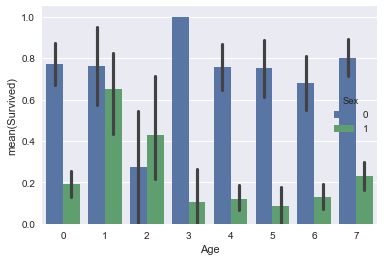

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.barplot(x = "Age", y = "Survived", hue = "Sex", data = data_train)

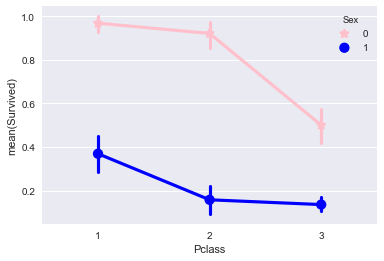

In [6]:
sns.pointplot(x = "Pclass", y = "Survived", hue = "Sex", 
              data = data_train, 
              palette = {1: "blue", 0: "pink"}, 
              markers = ["*", "o"], linestyle = ["-", "--"]);

### <font color="Indigo">9. データ可視化の結果について考察せよ</font>
##### ・上記の２つの可視化から分かったことについて考察せよ。
###### 答え:  
　一つ目のグラフからは、女性('Sex=0)においては、13歳から18歳までの'Teenager'の生存率が一番高く、6歳から12歳までの'Child'の生存率が一番低い。  
男性(Sex=1)においては、0歳から5歳までの'Baby'の生存率が一番高く、26歳から35歳まで'のYoung Adult'の生存率が一番低い。  
また、このグラフからは、女性においては、年齢の高低と生存率の関係は見られないが、男性においては、年齢が低い世代の生存率が高い。  
ただし、男性においては、一定の世代以降になると、年齢と生存率の関係は見られない。  
　つまり、年齢と生存率の相関関係は低く、女性の年齢ごとの生存率と男性の年齢ごとの生存率の相関関係も低いと推測できる。  

　二つ目のグラフからは、女性においては、チケットクラスが一番高いものが生存率も一番高く、チケットクラスが一番低いものが生存率も一番低い。　　
しかし、真ん中のチケットクラスの生存率は、一番高いチケットクラスの生存率に近い。  
男性においても、チケットクラスが一番高いものが生存率も一番高く、チケットクラスの一番低いものが生存率も一番低い。  
しかし、真ん中のチケットクラスの生存率は、一番低いチケットクラスの生存率に近い。  
　つまり、チケットクラスと生存率に強い相関関係があり、女性のチケットクラスごとの生存率と男性のチケットクラスごとの生存率にも、ある程度の相関関係があると推測できる。　　

##### ・上記の考察結果から、モデル選択を考える場合、どのようなことが考えられるか
###### 答え:  
　特徴量同士の相関関係が低いと推測できる一つ目のグラフのデータに対しては、相関関係が低くても予測できるモデルを選択する。  
一方、ある程度の相関関係が見られると推測できる二つ目のグラフのデータに対しては、相関関係が高い場合に予測できるモデルを選択することができる。  
　また、一つ目のグラフは年齢のデータが連続値となり得るため、回帰問題を扱えるモデルを選択することができる。  
一方、二つ目のグラフはチケットクラスが連続値ではないため、クラス分類問題を扱えるモデルを選択する必要がある。

### <font color="Indigo">10. データセットの分割</font>

In [7]:
from sklearn.model_selection import train_test_split
X = data_train.drop(["Survived", "PassengerId"], axis = 1)
y = data_train["Survived"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

### <font color="Indigo">11. ランダムフォレストについて記述せよ</font>
##### ・決定木とはどのような手法か
###### 答え:  
与えられる質問に対し、木構造を構築し、Yes/Noの形で分類する。  
##### ・ランダムフォレストとはどのような手法か
###### 答え:  
決定木の短所である過剰適合を回避するために、複数の異なるランダムな決定木を用いて分類する。
##### ・ランダムフォレストの長所と短所をそれぞれ3つ以上挙げてください。
###### 答え:  
長所①: 決定木と同様に、精度の高い予測が可能である  
長所②: 決定木の短所である、過剰適合を防ぐことができる  
長所③: それぞれの特徴量の重要度が信頼できる  
長所④: パラメータのチューニングをせずとも、高い性能が出る  

短所①: 精度の高く、かつ、お互いが異なる決定木を多く作成する必要がある  
短所②: 複数の決定木の予測プロセスをトレースすることは難しい  
短所③: 特徴量の数に応じ、決定木の構築に時間がかかる  
短所④: 決定木を作成する数を固定しておかないと、構築されるモデルが大きく変わってしまう可能性がある  
短所⑤: テキストデータなどでは、高い性能が出せない傾向にある  
##### ・今回の目的からランダムフォレストの手法が適する理由を考察し、記述せよ
###### 答え:  
理由1: 回帰問題とクラス分類の両方を扱うことができるから  
理由2: 最終的なアウトプットである生死の判定には決定木のモデルが適用できるから  

### <font color="Indigo">12. 学習</font>

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.model_selection import GridSearchCV

clf = RandomForestClassifier()
param_grid = {'n_estimators': [500],
              'max_features': ['log2', 'sqrt', 'auto'],
              'criterion':    ['entropy', 'gini'],
              'max_depth':    [2, 3, 5, 10],
              'min_samples_split': [2, 3, 5],
              'min_samples_leaf':  [1, 5, 8]}
acc_scorer = make_scorer(accuracy_score)
grid_search = GridSearchCV(clf, param_grid, scoring = acc_scorer)
grid_search = grid_search.fit(X_train, y_train)
clf = grid_search.best_estimator_
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=3, max_features='log2', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=8,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

### <font color="Indigo">13. accuracyを求めよ</font>

In [10]:
predictions = clf.predict(X_test)
print(accuracy_score(y_test, predictions))

0.832402234637


### <font color="Indigo">14. 精度を高める</font>
###### 答え:
精度が80%を超えているため、スキップします。    

### <font color="Indigo">15. ハイパーパラメータについて</font>
##### ・ハイパーパラメーターとは何か  
###### 答え:  
トレーニングデータではなく個別に最適化するためのチューニングパラメータのこと。  
##### ・ランダムフォレストにおいてどのようなハイパーパラメーターがあるか4つ以上記述せよ  
###### 答え:  
1. n_estimators  
   ランダムフォレストで構築する決定木の数(default = 10)。  
2. bootstrap  
   決定木を作る際に使用するデータをランダムに、お互いの決定木の間で重複ありで呼び出すためのパラメータ(default = True)。
3. max_features 
   決定木を構築するために使用する特徴量のサブセットの最大数(default = "auto")。  
   引数は次の通り。  
   auto: 特徴量の平方根  
   sqrt: 特徴量の平方根  
   log2: 2を底とする対数  
   None: 特徴量の数  
4. max_depth  
   決定木の深さの最大値(default = None)。  
5. criterion  
   決定木を構築するための基準(default = "gini")。  
   引数は次の通り。  
   gini: 不平等度を測定する尺度であるジニ計数を使用(回帰として最大値を見つけるものに向く)  
   entropy: 乱雑さを測定する尺度であるエントロピーを使用(クラス分類としてグルーピングするものに向く)  

##### ・記述したハイパーパラメーターにおいて、それぞれどのような値が存在するか記述せよ（そのハイパーパラメーターを変化させるとどのようなことが起きるかも記述すること）  
###### 答え:  
1. n_estimators  
   存在する値: 1, 2, 100, 500, [4, 6, 9]...  
   変化させることで起きること: 作成される決定木が増え、予測精度に影響を与える  
2. bootstrap  
   存在する値: True, False  
   変化させることで起きること: ブートストラップをするかしないか  
3. max_features  
   存在する値: "auto", "sqrt", "log2", "None"  
   変化させることで起きること: 識別性の高い特徴量を使い、訓練データへの適合が容易になる  
4. max_depth  
   存在する値: 1, 2, 100, [2, 3, 5]...  
   変化させることで起きること: 過学習の防止
5. criterion  
   存在する値: "gini", "entropy"  
   変化させることで起きること: 精度にあまり差はないが、"entropy"の方が計算が遅くなる傾向がある  

### <font color="Indigo">16. チューニング</font>
精度が80%を超えているため、チューニングはスキップします。  

### <font color="Indigo">17. 検証について記述せよ</font>
##### ・検証は何か
###### 答え:
汎化性能を評価する手法。   
##### ・なぜ検証を行う必要があるのか(Accuracyだけではダメな理由も含めること)
###### 答え:  
訓練データにのみ適合し、未知のデータの予測の精度が低い過学習したモデルになっていないことを確かめるため。  
Accuracyのスコアが高いということは分類がうまくいっていることを示すが、汎化性能を評価する指標になり得ないため。  
https://mahata.github.io/machine%20learning/2014/12/31/sklearn-accuracy_score/  
##### ・主な検証方法について2つ以上記述せよ
###### 答え:
1. ホールドアウト法  
2. k-分割交差検証

### <font color="Indigo">18. KFoldについて記述せよ</font>
##### ・K-分割交差検証について説明せよ
###### 答え:  
汎化性能を検証する手法の一つで、訓練データとテストデータをユーザが定める「k」個に分割し検証する。  
検証自体も「k」回実行し、そのうちの1回の検証で「k-1」個をテストに使用し、残りを訓練に使用する。
##### ・K-分割交差検証はデータセットを何個に分割するか
###### 答え:
データセットはユーザが決める「k」個に分割する。  
例えば、5個にした場合、1回の検証でテストデータを1、訓練データを4とする。  
##### ・データセットを分割する際、その個数はどのように考えると良いか
###### 答え:
検証の回数もデータセットを分割に指定した回数実行すると考える。  
##### ・K-分割交差検証は何回の検証を行うか
###### 答え:
検証はユーザが決める「k」回検証を行う。  
##### ・K-分割交差検証の結果は、最終的にどのように求められるか
###### 答え:
1回の検証でテストデータを「k-1」、訓練データをその残りを使用し、それを「k」回実行し、それぞれの検証ごとに精度を計算する。

### <font color="Indigo">19. KFoldを実施する</font>

In [11]:
from sklearn.cross_validation import KFold

def run_kfold(clf):
    kf = KFold(891, n_folds = 10)
    result = []
    fold = 0
    for train_index, test_index in kf:
        fold += 1
        X_train, X_test = X.values[train_index], X.values[test_index]
        y_train, y_test = y.values[train_index], y.values[test_index]
        clf.fit(X_train, y_train)
        predictions = clf.predict(X_test)
        accuracy = accuracy_score(y_test, predictions)
        result.append(accuracy)
        print("Fold'{0}'の精度:{1}".format(fold, accuracy))
    mean_result = np.mean(result)
    print("精度の平均:{0}".format(mean_result))

run_kfold(clf)

Fold'1'の精度:0.7111111111111111
Fold'2'の精度:0.8314606741573034
Fold'3'の精度:0.7752808988764045
Fold'4'の精度:0.8089887640449438
Fold'5'の精度:0.8539325842696629
Fold'6'の精度:0.8202247191011236
Fold'7'の精度:0.7640449438202247
Fold'8'の精度:0.7640449438202247
Fold'9'の精度:0.8651685393258427
Fold'10'の精度:0.8202247191011236
精度の平均:0.8014481897627965


### <font color="Indigo">20. Kfoldの結果を確認する</font>
###### 答え:
Mean Accuracyが80%を超えているため、チューニングはスキップします。

### <font color="Indigo">21. どの特徴量が重要であったかを調査する</font>

([<matplotlib.axis.YTick at 0x11343a828>,
 <a list of 10 Text yticklabel objects>)

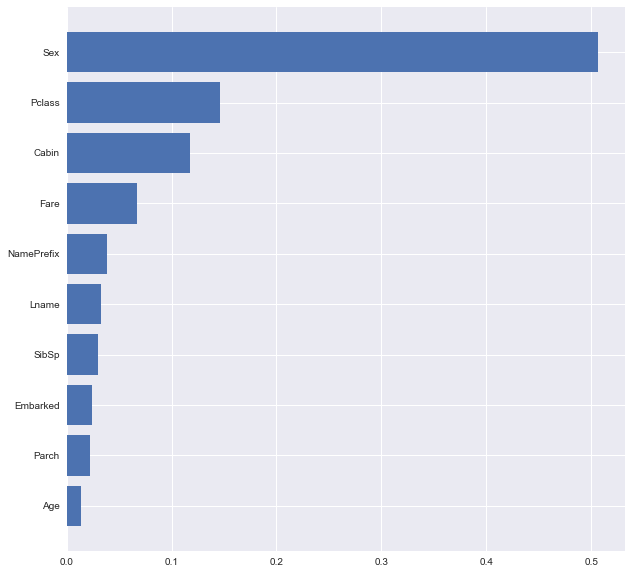

In [12]:
values, names = zip(*sorted(zip(clf.feature_importances_, X.columns)))
plt.figure(figsize = (10, 10))
plt.barh(range(len(names)), values, align = 'center')
plt.yticks(range(len(names)), names)